# Model Training: Linear Regression, Random Forest, XGBoost
## Stanford TECH 27 Final Project - Notebook 06

This notebook trains and compares three regression models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import warnings
import pickle
from pathlib import Path
import sys
sys.path.append('.')
from data_processing_utils import filter_features, get_realistic_features

warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Processed Data

Load the final processed datasets from notebook 05.

In [2]:
# Load processed data from notebook 05_final_processing.ipynb
OUTPUT_DIR = Path('processed_data')
ml_datasets_path = OUTPUT_DIR / 'final_ml_ml_datasets.pkl'

if ml_datasets_path.exists():
    print(f"Loading processed datasets from {ml_datasets_path}...")
    with open(ml_datasets_path, 'rb') as f:
        ml_datasets = pickle.load(f)
    
    # Extract the full datasets
    X_train_full = ml_datasets['X_train']
    X_val_full = ml_datasets['X_val']
    X_test_full = ml_datasets['X_test']
    y_train = ml_datasets['y_train']
    y_val = ml_datasets['y_val']
    y_test = ml_datasets['y_test']
    
    # Get all feature names
    all_feature_cols = ml_datasets.get('feature_cols', 
                                       [f'feature_{i}' for i in range(X_train_full.shape[1])])
    
    print(f"✅ Successfully loaded datasets from notebook 5")
    print(f"Full dataset: {X_train_full.shape[0]} training samples, {X_train_full.shape[1]} features")
    print(f"\nAll available features ({len(all_feature_cols)}):")
    for i, feat in enumerate(all_feature_cols, 1):
        print(f"{i:3d}. {feat}")
    
else:
    print(f"❌ Error: Could not find {ml_datasets_path}")
    print("Please run notebook 05_final_processing.ipynb first to generate the datasets.")
    raise FileNotFoundError(f"Dataset file not found: {ml_datasets_path}")

Loading processed datasets from processed_data/final_ml_ml_datasets.pkl...
✅ Successfully loaded datasets from notebook 5
Full dataset: 326540 training samples, 45 features

All available features (45):
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. temperature_change
 13. power_change
 14. voltage_rolling_mean_5
 15. current_rolling_mean_5
 16. temperature_rolling_mean_5
 17. voltage_rolling_std_5
 18. current_rolling_std_5
 19. voltage_rolling_mean_10
 20. current_rolling_mean_10
 21. temperature_rolling_mean_10
 22. voltage_rolling_std_10
 23. current_rolling_std_10
 24. voltage_rolling_mean_20
 25. current_rolling_mean_20
 26. temperature_rolling_mean_20
 27. voltage_rolling_std_20
 28. current_rolling_std_20
 29. cumulative_discharge
 30. cumulative_energy
 31. time_normalized
 32. time_since_start
 33. voltage_lag_1
 34. current_lag_1
 35

## Filter Features 

Filter the dataset to use only the specified realistic features that would be available from V, I, T measurements. Specifically exclude the SOC lag features we created (predicting SOC from what SOC was 2 seconds ago is too easy).

In [3]:
# Get the standard list of realistic features from centralized function
features = get_realistic_features()

# Use the centralized filter_features function to filter datasets
filtered_data = filter_features(
    X_train_full, X_val_full, X_test_full,
    all_feature_cols, features,
    y_train=y_train, y_val=y_val, y_test=y_test,
    verbose=True
)

# Extract the filtered datasets
X_train = filtered_data['X_train']
X_val = filtered_data['X_val']
X_test = filtered_data['X_test']
available_realistic = filtered_data['available_features']


Feature Selection Summary:
   Total features in dataset: 45
   Features requested: 24
   Features available: 24
   Features excluded: 21

Filtered dataset shapes:
   Training:   X=(326540, 24), y=(326540,)
   Validation: X=(101570, 24), y=(101570,)
   Test:       X=(113400, 24), y=(113400,)

Feature reduction: 45 → 24 features

Using 24 features:
  1. voltage
  2. current
  3. temperature
  4. Current_load
  5. Voltage_load
  6. power
  7. abs_current
  8. voltage_current_ratio
  9. energy
 10. voltage_change
 11. current_change
 12. power_change
 13. temperature_change
 14. voltage_rolling_mean_5
 15. voltage_rolling_mean_10
 16. voltage_rolling_std_5
 17. voltage_rolling_std_10
 18. current_rolling_mean_5
 19. current_rolling_mean_10
 20. current_rolling_std_5
 21. current_rolling_std_10
 22. voltage_lag_1
 23. current_lag_1
 24. cumulative_energy


## Create Filtered Datasets

Filter the X datasets to only include the selected features.

## Model Training and Evaluation Functions

Utility functions for model training, prediction, and evaluation.

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance with multiple metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Convert to percentage for SOC
    rmse_percent = rmse * 100
    mae_percent = mae * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f} ({rmse_percent:.3f}% SOC)")
    print(f"  MAE: {mae:.6f} ({mae_percent:.3f}% SOC)")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2,
            'rmse_percent': rmse_percent, 'mae_percent': mae_percent}

def plot_predictions(y_true, y_pred, model_name, dataset_name=''):
    """Plot predicted vs actual values."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true * 100, y_pred * 100, alpha=0.6, s=1)
    
    # Plot perfect prediction line
    plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
    
    plt.xlabel('Actual SOC (%)')
    plt.ylabel('Predicted SOC (%)')
    plt.title(f'{model_name} - Predicted vs Actual {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    rmse_percent = np.sqrt(mean_squared_error(y_true, y_pred)) * 100
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse_percent:.2f}%', 
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name, dataset_name=''):
    """Plot residuals to check for patterns."""
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted
    axes[0].scatter(y_pred * 100, residuals, alpha=0.6, s=1)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Predicted SOC (%)')
    axes[0].set_ylabel('Residuals (% SOC)')
    axes[0].set_title(f'{model_name} - Residuals vs Predicted {dataset_name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Residuals (% SOC)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name} - Residuals Distribution {dataset_name}')
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    axes[1].axvline(x=mean_res, color='red', linestyle='--', label=f'Mean: {mean_res:.3f}%')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## 6. Linear Regression Model

In [5]:
print("="*60)
print("TRAINING LINEAR REGRESSION")
print("="*60)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)
lr_test_pred = lr_model.predict(X_test)

# Evaluate performance
lr_train_metrics = evaluate_model(y_train, lr_train_pred, "Linear Regression (Training)")
lr_val_metrics = evaluate_model(y_val, lr_val_pred, "Linear Regression (Validation)")
lr_test_metrics = evaluate_model(y_test, lr_test_pred, "Linear Regression (Test)")

print("\nLinear Regression training completed.")

TRAINING LINEAR REGRESSION

Linear Regression (Training) Performance:
  R² Score: 0.707273
  RMSE: 0.123068 (12.307% SOC)
  MAE: 0.092856 (9.286% SOC)

Linear Regression (Validation) Performance:
  R² Score: 0.681047
  RMSE: 0.121321 (12.132% SOC)
  MAE: 0.082818 (8.282% SOC)

Linear Regression (Test) Performance:
  R² Score: 0.208879
  RMSE: 0.197562 (19.756% SOC)
  MAE: 0.108510 (10.851% SOC)

Linear Regression training completed.


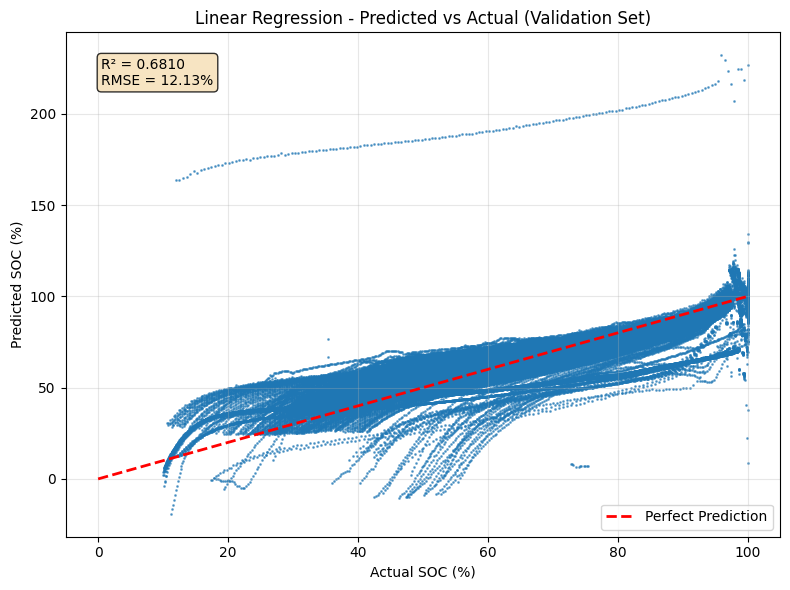

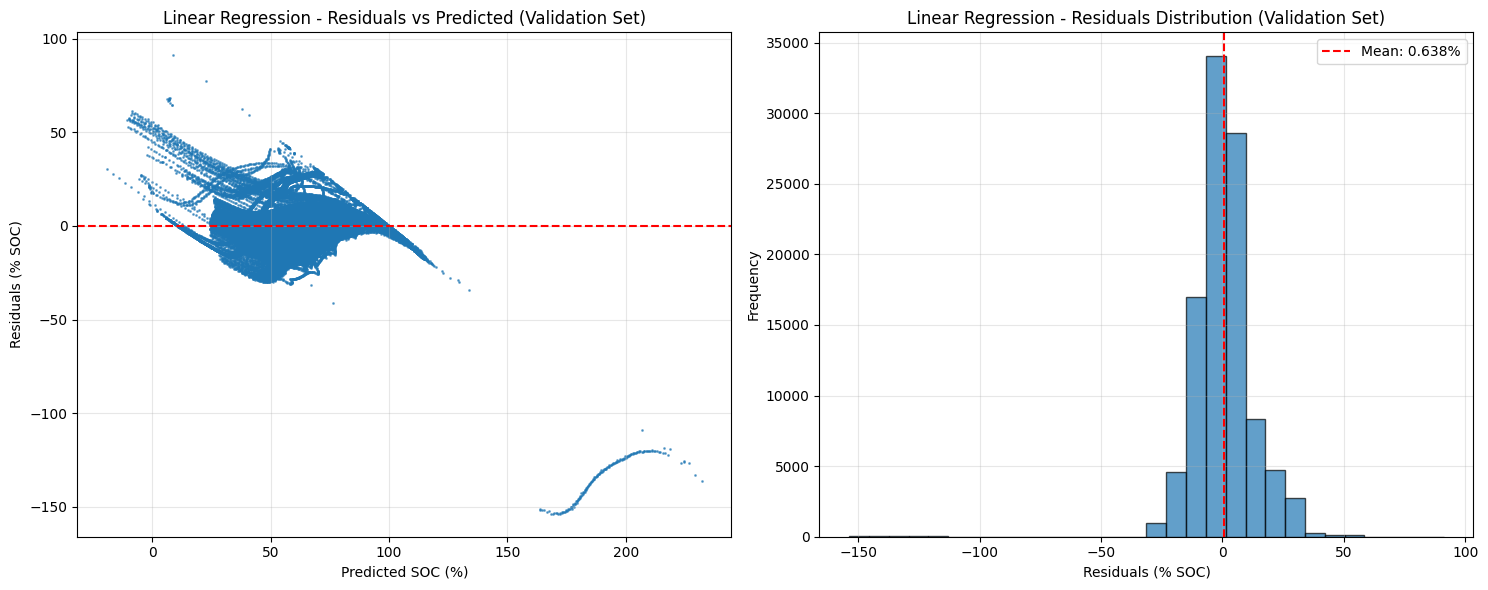

In [6]:
# Visualize Linear Regression results
plot_predictions(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")
plot_residuals(y_val, lr_val_pred, "Linear Regression", "(Validation Set)")

In [7]:
print("="*60)
print("TRAINING RANDOM FOREST")
print("="*60)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_test_pred = rf_model.predict(X_test)

# Evaluate performance
rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest (Training)")
rf_val_metrics = evaluate_model(y_val, rf_val_pred, "Random Forest (Validation)")
rf_test_metrics = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")

print("\nRandom Forest training completed.")

TRAINING RANDOM FOREST

Random Forest (Training) Performance:
  R² Score: 0.999856
  RMSE: 0.002729 (0.273% SOC)
  MAE: 0.001213 (0.121% SOC)

Random Forest (Validation) Performance:
  R² Score: 0.871024
  RMSE: 0.077148 (7.715% SOC)
  MAE: 0.053952 (5.395% SOC)

Random Forest (Test) Performance:
  R² Score: 0.917825
  RMSE: 0.063672 (6.367% SOC)
  MAE: 0.046629 (4.663% SOC)

Random Forest training completed.


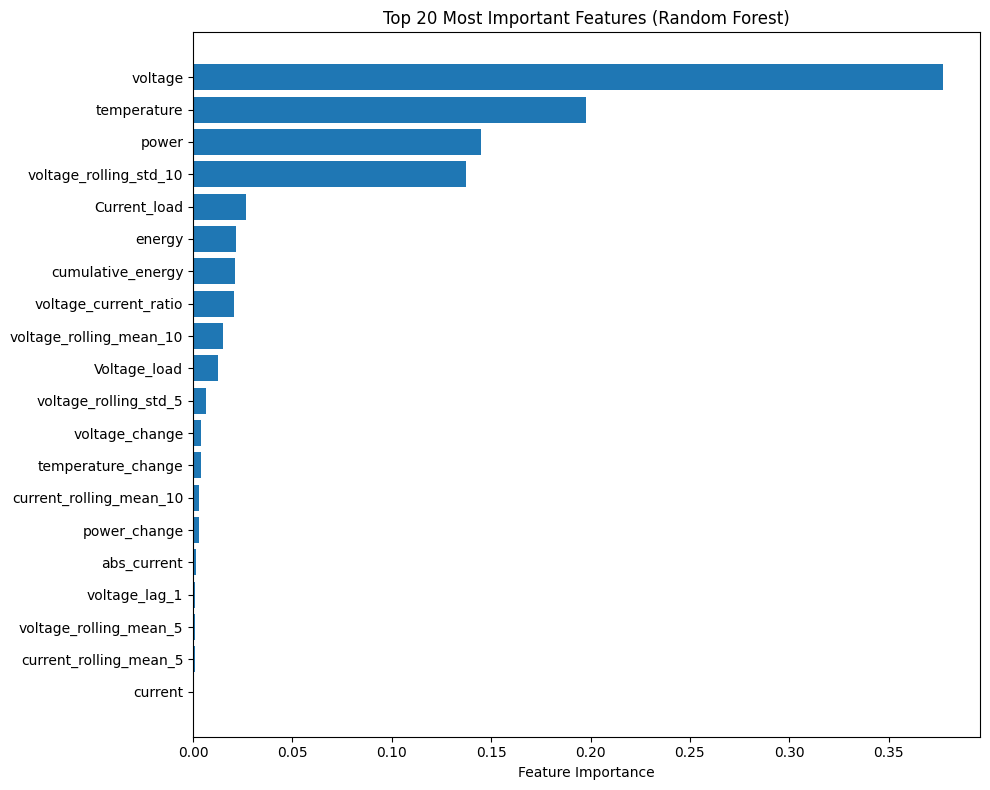


Top 10 most important features:
                feature  importance
                voltage    0.377155
            temperature    0.197479
                  power    0.144875
 voltage_rolling_std_10    0.137484
           Current_load    0.026549
                 energy    0.021634
      cumulative_energy    0.021023
  voltage_current_ratio    0.020579
voltage_rolling_mean_10    0.014882
           Voltage_load    0.012434


In [8]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': available_realistic,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features (or all if less than 20)
n_features_to_plot = min(20, len(feature_importance))
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(n_features_to_plot)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_features_to_plot} Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

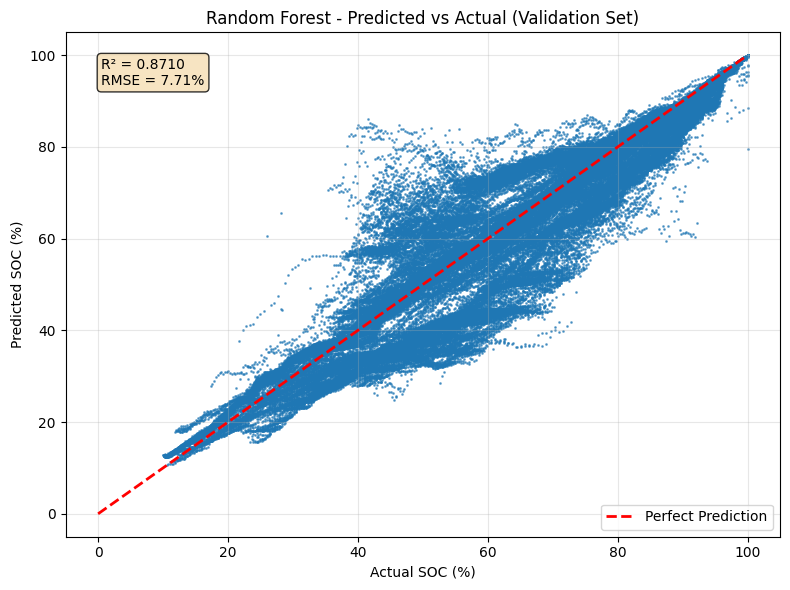

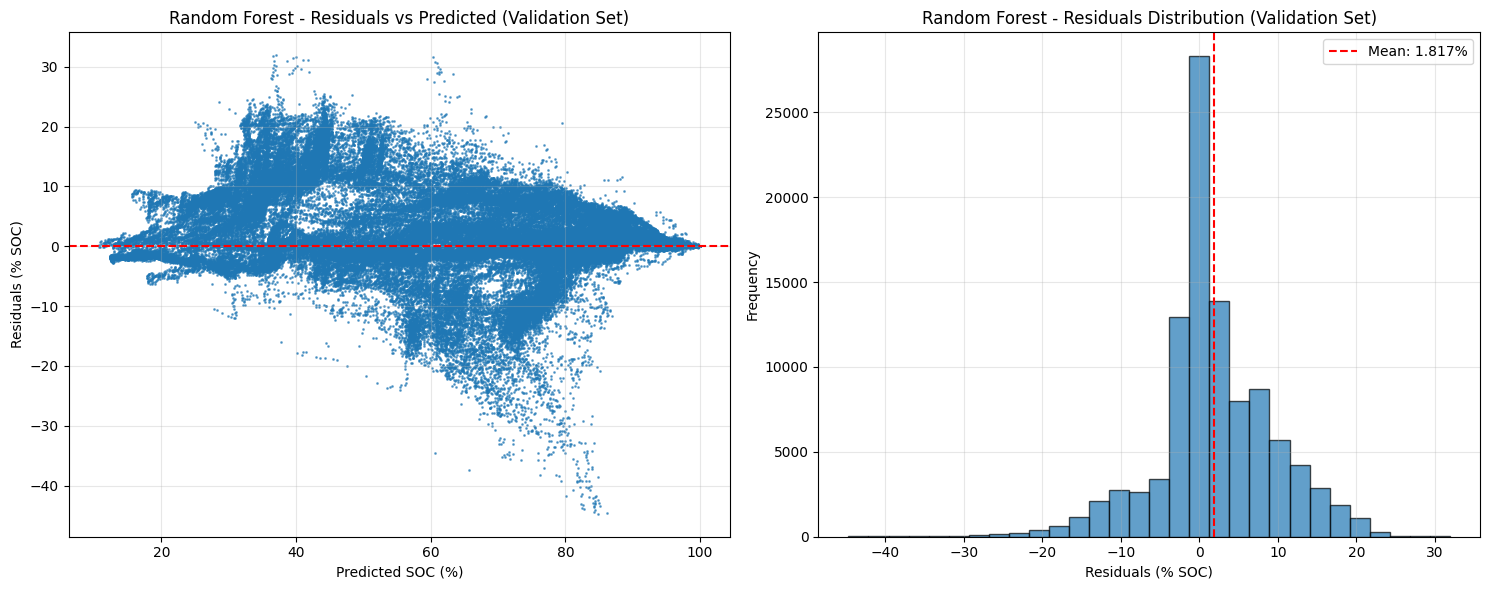

In [9]:
# Visualize Random Forest results
plot_predictions(y_val, rf_val_pred, "Random Forest", "(Validation Set)")
plot_residuals(y_val, rf_val_pred, "Random Forest", "(Validation Set)")

## 8. XGBoost Model

In [10]:
print("="*60)
print("TRAINING XGBOOST")
print("="*60)

# Train XGBoost with early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=2.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100,
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Best iteration:", xgb_model.best_iteration)
print("Best valid RMSE:", xgb_model.best_score)

# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate performance
xgb_train_metrics = evaluate_model(y_train, xgb_train_pred, "XGBoost (Training)")
xgb_val_metrics = evaluate_model(y_val, xgb_val_pred, "XGBoost (Validation)")
xgb_test_metrics = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")

print("\nXGBoost training completed.")

TRAINING XGBOOST
Best iteration: 311
Best valid RMSE: 0.07920521713472506

XGBoost (Training) Performance:
  R² Score: 0.960371
  RMSE: 0.045282 (4.528% SOC)
  MAE: 0.030291 (3.029% SOC)

XGBoost (Validation) Performance:
  R² Score: 0.864056
  RMSE: 0.079205 (7.921% SOC)
  MAE: 0.057899 (5.790% SOC)

XGBoost (Test) Performance:
  R² Score: 0.904824
  RMSE: 0.068524 (6.852% SOC)
  MAE: 0.051587 (5.159% SOC)

XGBoost training completed.


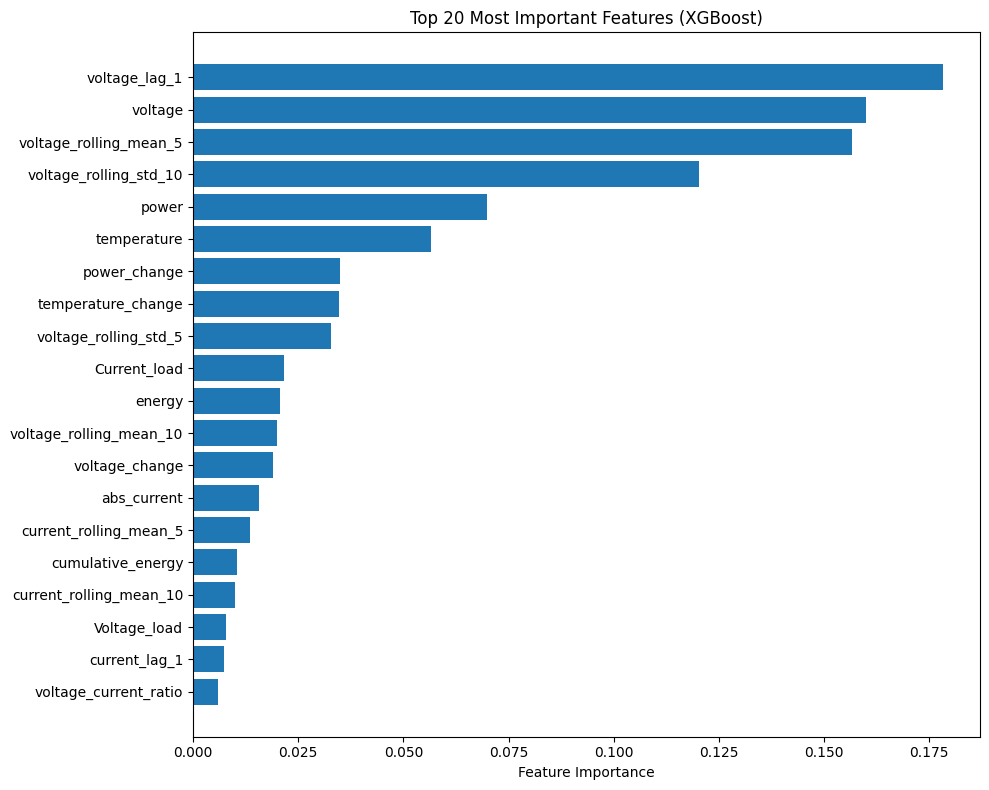


Top 10 most important features (XGBoost):
               feature  importance
         voltage_lag_1    0.178183
               voltage    0.160076
voltage_rolling_mean_5    0.156594
voltage_rolling_std_10    0.120344
                 power    0.069788
           temperature    0.056545
          power_change    0.035026
    temperature_change    0.034583
 voltage_rolling_std_5    0.032900
          Current_load    0.021615


In [11]:
# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': available_realistic,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 most important features (or all if less than 20)
n_features_to_plot = min(20, len(xgb_importance))
plt.figure(figsize=(10, 8))
top_xgb_features = xgb_importance.head(n_features_to_plot)
plt.barh(range(len(top_xgb_features)), top_xgb_features['importance'])
plt.yticks(range(len(top_xgb_features)), top_xgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_features_to_plot} Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features (XGBoost):")
print(xgb_importance.head(10).to_string(index=False))

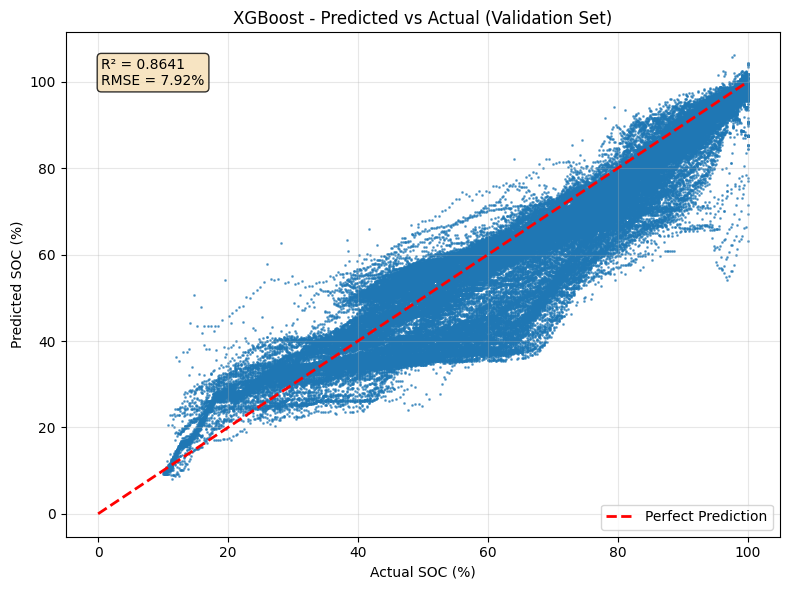

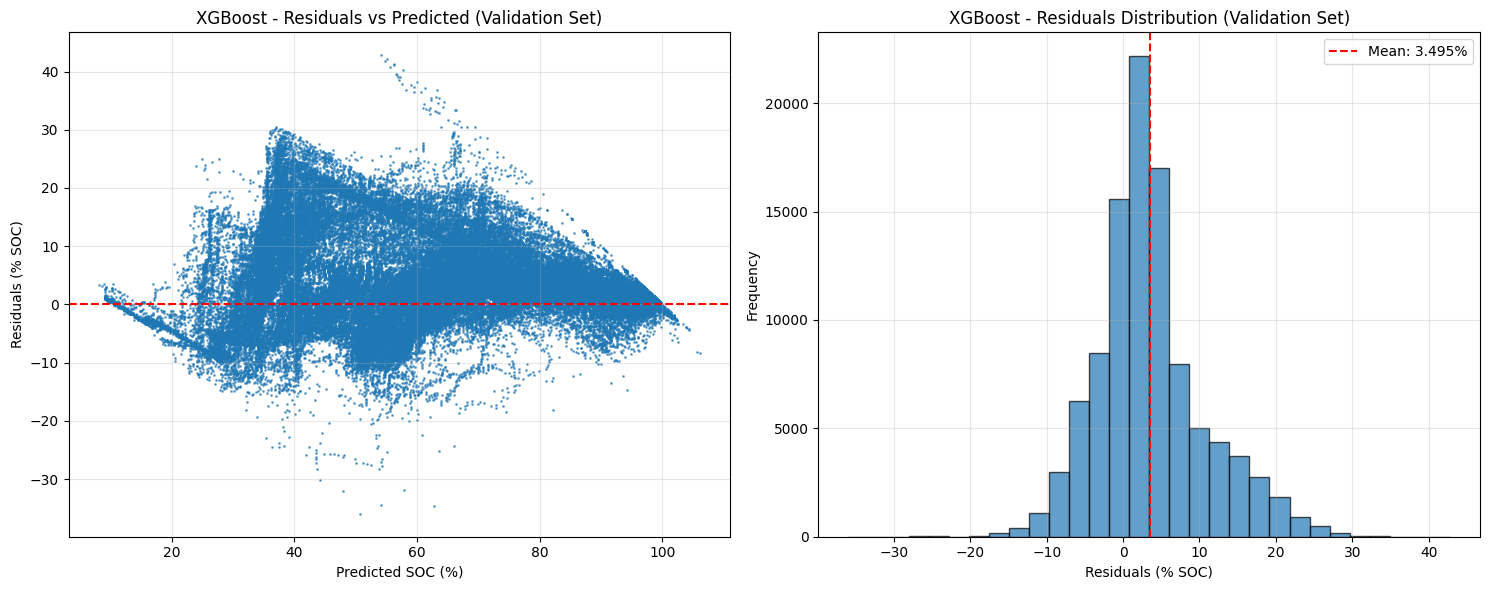

In [12]:
# Visualize XGBoost results
plot_predictions(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")
plot_residuals(y_val, xgb_val_pred, "XGBoost", "(Validation Set)")

## 9. Model Comparison


MODEL PERFORMANCE COMPARISON

Using 24 features

            Model  Training_R2  Training_RMSE_%  Validation_R2  Validation_RMSE_%  Test_R2  Test_RMSE_%
Linear Regression       0.7073          12.3068         0.6810            12.1321   0.2089      19.7562
    Random Forest       0.9999           0.2729         0.8710             7.7148   0.9178       6.3672
          XGBoost       0.9604           4.5282         0.8641             7.9205   0.9048       6.8524


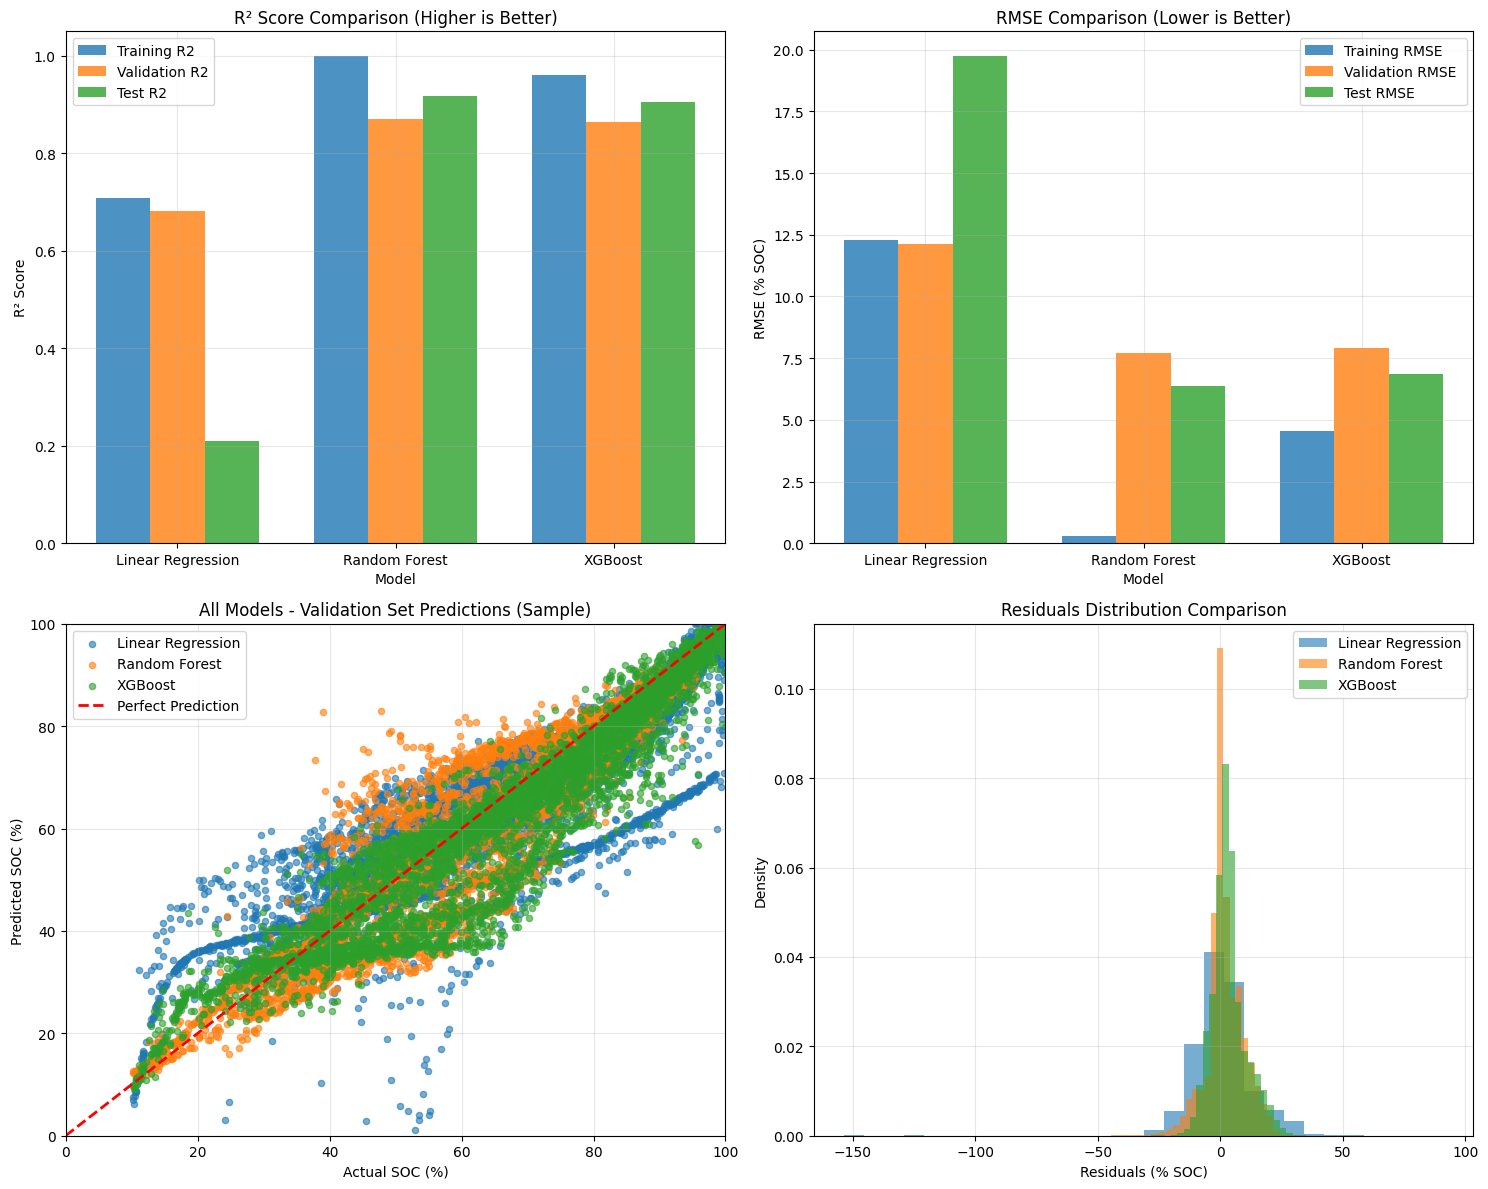

In [13]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Training_R2': [lr_train_metrics['r2'], rf_train_metrics['r2'], xgb_train_metrics['r2']],
    'Training_RMSE_%': [lr_train_metrics['rmse_percent'], rf_train_metrics['rmse_percent'], xgb_train_metrics['rmse_percent']],
    'Validation_R2': [lr_val_metrics['r2'], rf_val_metrics['r2'], xgb_val_metrics['r2']],
    'Validation_RMSE_%': [lr_val_metrics['rmse_percent'], rf_val_metrics['rmse_percent'], xgb_val_metrics['rmse_percent']],
    'Test_R2': [lr_test_metrics['r2'], rf_test_metrics['r2'], xgb_test_metrics['r2']],
    'Test_RMSE_%': [lr_test_metrics['rmse_percent'], rf_test_metrics['rmse_percent'], xgb_test_metrics['rmse_percent']]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"\nUsing {len(available_realistic)} features\n")
print(results_df.round(4).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
metrics = ['Training_R2', 'Validation_R2', 'Test_R2']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' '), alpha=0.8)

axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('R² Score Comparison (Higher is Better)')
axes[0, 0].set_xticks(x_pos + width)
axes[0, 0].set_xticklabels(results_df['Model'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison
rmse_metrics = ['Training_RMSE_%', 'Validation_RMSE_%', 'Test_RMSE_%']
for i, metric in enumerate(rmse_metrics):
    axes[0, 1].bar(x_pos + i*width, results_df[metric], width, 
                   label=metric.replace('_', ' ').replace('%', ''), alpha=0.8)

axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('RMSE (% SOC)')
axes[0, 1].set_title('RMSE Comparison (Lower is Better)')
axes[0, 1].set_xticks(x_pos + width)
axes[0, 1].set_xticklabels(results_df['Model'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction comparison on validation set
sample_size = min(5000, len(y_val))
sample_idx = np.random.choice(len(y_val), sample_size, replace=False)

# Convert to numpy arrays if needed and use iloc for indexing
y_val_array = np.array(y_val)
lr_val_pred_array = np.array(lr_val_pred)
rf_val_pred_array = np.array(rf_val_pred)
xgb_val_pred_array = np.array(xgb_val_pred)

axes[1, 0].scatter(y_val_array[sample_idx] * 100, lr_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='Linear Regression', s=20)
axes[1, 0].scatter(y_val_array[sample_idx] * 100, rf_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='Random Forest', s=20)
axes[1, 0].scatter(y_val_array[sample_idx] * 100, xgb_val_pred_array[sample_idx] * 100, 
                  alpha=0.6, label='XGBoost', s=20)

axes[1, 0].plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual SOC (%)')
axes[1, 0].set_ylabel('Predicted SOC (%)')
axes[1, 0].set_title('All Models - Validation Set Predictions (Sample)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 100])
axes[1, 0].set_ylim([0, 100])

# Residuals comparison
lr_residuals = (y_val_array - lr_val_pred_array) * 100
rf_residuals = (y_val_array - rf_val_pred_array) * 100
xgb_residuals = (y_val_array - xgb_val_pred_array) * 100

axes[1, 1].hist(lr_residuals, alpha=0.6, label='Linear Regression', bins=30, density=True)
axes[1, 1].hist(rf_residuals, alpha=0.6, label='Random Forest', bins=30, density=True)
axes[1, 1].hist(xgb_residuals, alpha=0.6, label='XGBoost', bins=30, density=True)
axes[1, 1].set_xlabel('Residuals (% SOC)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Residuals Distribution Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [15]:
print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)

print("\nDataset Configuration:")
print(f"   Total features available: {len(all_feature_cols)}")
print(f"   Training samples: {X_train.shape[0]:,}")
print(f"   Validation samples: {X_val.shape[0]:,}")
print(f"   Test samples: {X_test.shape[0]:,}")

print("\nPerformance Summary (Test Set):")
for idx, row in results_df.iterrows():
    print(f"   {row['Model']:20s}: R²={row['Test_R2']:.6f}, RMSE={row['Test_RMSE_%']:.3f}% SOC")

# Check for overfitting
print("\nOverfitting Analysis:")
for idx, row in results_df.iterrows():
    train_r2 = row['Training_R2']
    val_r2 = row['Validation_R2']
    gap = train_r2 - val_r2
    
    status = "✅ Good" if gap < 0.05 else "⚠️ Mild" if gap < 0.1 else "❌ Severe"
    print(f"   {row['Model']:20s}: Train-Val R² gap = {gap:.4f} ({status})")

MODEL TRAINING SUMMARY

Dataset Configuration:
   Total features available: 45
   Training samples: 326,540
   Validation samples: 101,570
   Test samples: 113,400

Performance Summary (Test Set):
   Linear Regression   : R²=0.208879, RMSE=19.756% SOC
   Random Forest       : R²=0.917825, RMSE=6.367% SOC
   XGBoost             : R²=0.904824, RMSE=6.852% SOC

Overfitting Analysis:
   Linear Regression   : Train-Val R² gap = 0.0262 (✅ Good)
   Random Forest       : Train-Val R² gap = 0.1288 (❌ Severe)
   XGBoost             : Train-Val R² gap = 0.0963 (⚠️ Mild)
